In [2]:
import optpricer as op

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D surfaces

import optpricer as op

# Base contract / market setup (edit as desired)
S0   = 100.0
K    = 100.0
T    = 1.00   # years
r    = 0.03
q    = 0.00
sig  = 0.20

base = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=sig, q=q)

# Common grids
S_vals = np.linspace(0.5*S0, 1.5*S0, 161)
T_vals = np.linspace(1/365, 2.0, 121)   # ~1 trading day to 2y
K_vals = np.linspace(0.6*S0, 1.4*S0, 81)


In [20]:
S_vals

array([ 60.        ,  60.66666667,  61.33333333,  62.        ,
        62.66666667,  63.33333333,  64.        ,  64.66666667,
        65.33333333,  66.        ,  66.66666667,  67.33333333,
        68.        ,  68.66666667,  69.33333333,  70.        ,
        70.66666667,  71.33333333,  72.        ,  72.66666667,
        73.33333333,  74.        ,  74.66666667,  75.33333333,
        76.        ,  76.66666667,  77.33333333,  78.        ,
        78.66666667,  79.33333333,  80.        ,  80.66666667,
        81.33333333,  82.        ,  82.66666667,  83.33333333,
        84.        ,  84.66666667,  85.33333333,  86.        ,
        86.66666667,  87.33333333,  88.        ,  88.66666667,
        89.33333333,  90.        ,  90.66666667,  91.33333333,
        92.        ,  92.66666667,  93.33333333,  94.        ,
        94.66666667,  95.33333333,  96.        ,  96.66666667,
        97.33333333,  98.        ,  98.66666667,  99.33333333,
       100.        , 100.66666667, 101.33333333, 102.  

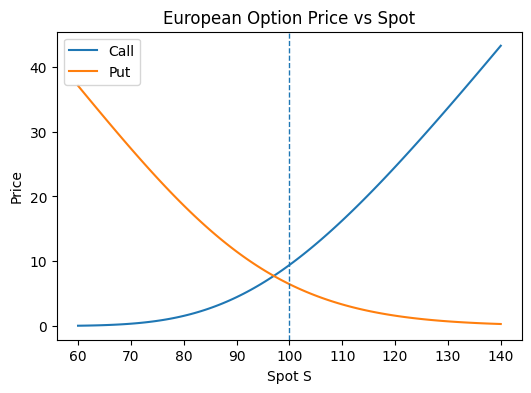

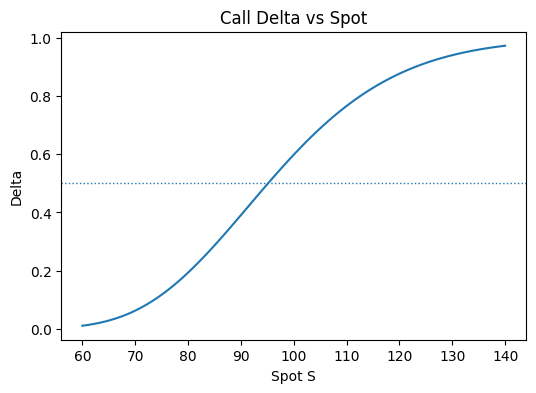

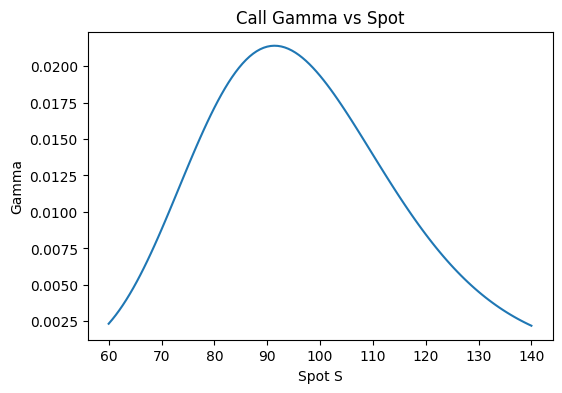

In [25]:
# Price vs Spot
call_px, put_px = [], []
for s in S_vals:
    spec = op.OptionSpec(S0=float(s), K=K, T=T, r=r, sigma=sig, q=q)
    call_px.append(op.bs_price(spec, kind=op.CALL))
    put_px.append( op.bs_price(spec, kind=op.PUT))

plt.figure(figsize=(6,4))
plt.plot(S_vals, call_px, label="Call")
plt.plot(S_vals, put_px,  label="Put")
plt.axvline(K, linestyle="--", linewidth=1)
plt.xlabel("Spot S"); plt.ylabel("Price"); plt.title("European Option Price vs Spot")
plt.legend(); plt.show()

# Greeks vs Spot (Delta & Gamma for a call)
delta_call, gamma_call = [], []
for s in S_vals:
    spec = op.OptionSpec(S0=float(s), K=K, T=T, r=r, sigma=sig, q=q)
    g = op.bs_greeks(spec, kind=op.CALL)
    # support dict or object return types:
    d  = g["delta"] if isinstance(g, dict) else g.delta
    gm = g["gamma"] if isinstance(g, dict) else g.gamma
    delta_call.append(d); gamma_call.append(gm)

plt.figure(figsize=(6,4))
plt.plot(S_vals, delta_call)
plt.axhline(0.5, linestyle=":", linewidth=1)
plt.xlabel("Spot S"); plt.ylabel("Delta"); plt.title("Call Delta vs Spot"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(S_vals, gamma_call)
plt.xlabel("Spot S"); plt.ylabel("Gamma"); plt.title("Call Gamma vs Spot"); plt.show()


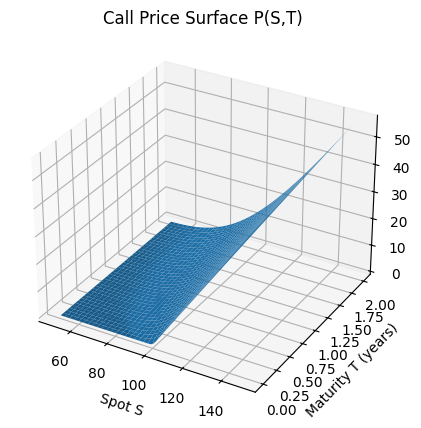

In [6]:
Sg, Tg = np.meshgrid(S_vals, T_vals, indexing="xy")
Z = np.empty_like(Sg, dtype=float)

for i in range(Tg.shape[0]):
    for j in range(Sg.shape[1]):
        spec = op.OptionSpec(S0=float(Sg[i,j]), K=K, T=float(Tg[i,j]), r=r, sigma=sig, q=q)
        Z[i, j] = op.bs_price(spec, kind=op.CALL)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Sg, Tg, Z, linewidth=0, antialiased=True)
ax.set_xlabel("Spot S"); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("Price")
ax.set_title("Call Price Surface P(S,T)")
plt.show()


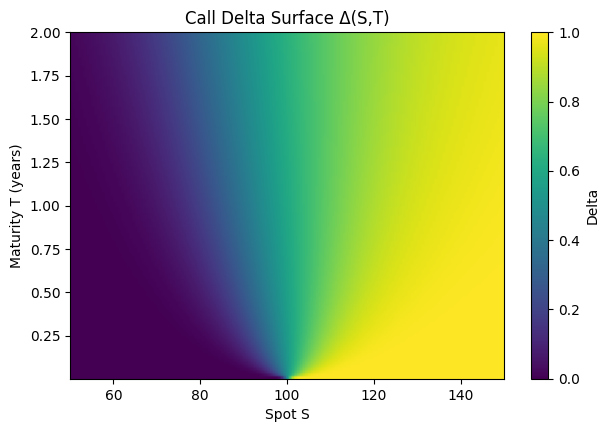

In [7]:
Delta = np.empty_like(Sg, dtype=float)
for i in range(Tg.shape[0]):
    for j in range(Sg.shape[1]):
        spec = op.OptionSpec(S0=float(Sg[i,j]), K=K, T=float(Tg[i,j]), r=r, sigma=sig, q=q)
        g = op.bs_greeks(spec, kind=op.CALL)
        Delta[i, j] = g["delta"] if isinstance(g, dict) else g.delta

plt.figure(figsize=(7,4.5))
plt.imshow(Delta, origin="lower", aspect="auto",
           extent=[S_vals.min(), S_vals.max(), T_vals.min(), T_vals.max()])
plt.colorbar(label="Delta")
plt.xlabel("Spot S"); plt.ylabel("Maturity T (years)")
plt.title("Call Delta Surface Δ(S,T)")
plt.show()


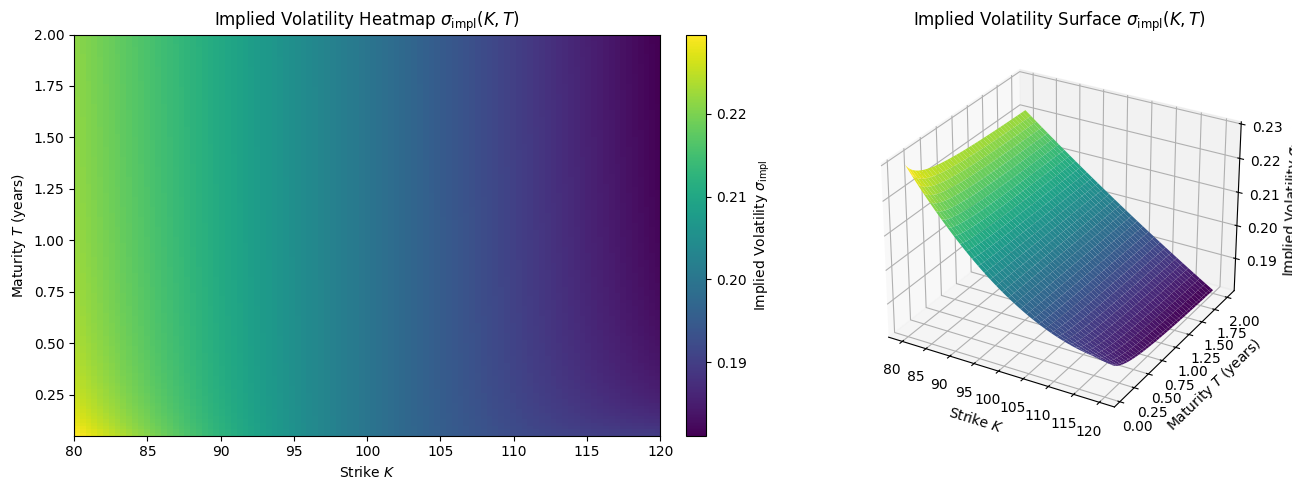

In [8]:
# Cell 5b — Implied Vol Surface (robust + LaTeX titles)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import optpricer as op

S0 = globals().get("S0", 100.0)
r  = globals().get("r", 0.03)
q  = globals().get("q", 0.00)

K_vals = np.linspace(0.8*S0, 1.2*S0, 101)   # 80%–120% moneyness
T_vals = np.linspace(0.05, 2.0, 121)        # 0.05y to 2 years

def toy_smile_sigma(S, K, T, base=0.20, skew=-0.10, curvature=0.30, floor=0.05):
    m = K / S - 1.0
    sig = base + skew*m + curvature*m*m*(1.0/(1.0+5*T))
    return max(floor, sig)

IV = np.full((len(T_vals), len(K_vals)), np.nan, dtype=float)

for i, T_ in enumerate(T_vals):
    for j, K_ in enumerate(K_vals):
        sig_true  = toy_smile_sigma(S0, K_, T_)
        spec_true = op.OptionSpec(S0=S0, K=K_, T=T_, r=r, sigma=sig_true, q=q)
        px_mkt    = op.bs_price(spec_true, kind=op.CALL)

        lower = max(1e-6, 0.5*sig_true)
        upper = min(5.0, 2.0*sig_true)
        try:
            IV[i, j] = op.implied_vol(spec_true, px_mkt, kind=op.CALL, bracket=(lower, upper))
        except ValueError:
            try:
                IV[i, j] = op.implied_vol(spec_true, px_mkt, kind=op.CALL,
                                          bracket=(1e-6, max(5.0, 3.0*sig_true + 0.5)))
            except ValueError:
                pass

K_mesh, T_mesh = np.meshgrid(K_vals, T_vals, indexing="xy")
Z = np.ma.masked_invalid(IV)

fig = plt.figure(figsize=(14,5))

# Heatmap
ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(Z, origin="lower", aspect="auto",
                extent=[K_vals.min(), K_vals.max(), T_vals.min(), T_vals.max()],
                cmap="viridis")
cbar = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label(r"Implied Volatility $\sigma_{\text{impl}}$")
ax1.set_xlabel(r"Strike $K$")
ax1.set_ylabel(r"Maturity $T$ (years)")
ax1.set_title(r"Implied Volatility Heatmap $\sigma_{\text{impl}}(K,T)$")

# 3D surface
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
surf = ax2.plot_surface(K_mesh, T_mesh, Z, cmap="viridis", linewidth=0, antialiased=True)
ax2.set_xlabel(r"Strike $K$")
ax2.set_ylabel(r"Maturity $T$ (years)")
ax2.set_zlabel(r"Implied Volatility $\sigma_{\text{impl}}$")
ax2.set_title(r"Implied Volatility Surface $\sigma_{\text{impl}}(K,T)$")
ax2.view_init(elev=28, azim=-60)

plt.tight_layout()
plt.show()


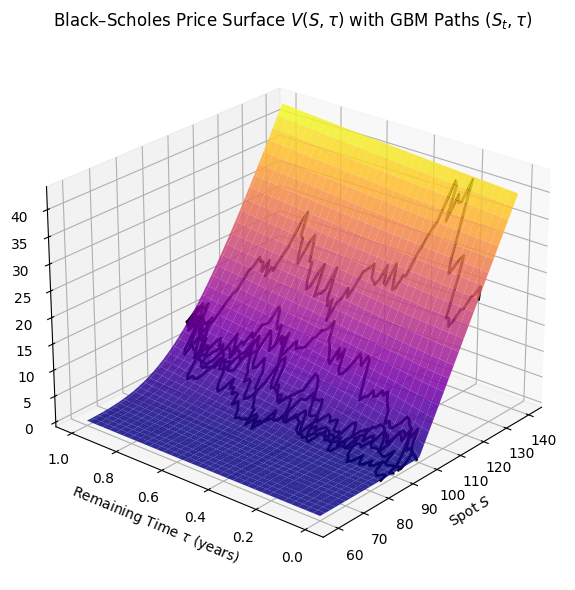

In [9]:
# Cell A — Price surface V(S, τ) with GBM paths (risk-neutral)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import optpricer as op

# Use globals from earlier cells if present; otherwise set defaults
S0 = globals().get("S0", 100.0)
K  = globals().get("K",  100.0)
T  = globals().get("T",    1.00)  # years
r  = globals().get("r",    0.03)
q  = globals().get("q",    0.00)
sig= globals().get("sig",  0.20)

# ----- grid for surface (spot S vs remaining time τ) -----
S_vals  = np.linspace(0.6*S0, 1.4*S0, 121)
Tau_vals= np.linspace(1e-4, T, 101)  # τ = time-to-maturity
Sg, Tg = np.meshgrid(S_vals, Tau_vals, indexing="xy")

V = np.empty_like(Sg, dtype=float)
for i, tau in enumerate(Tau_vals):
    for j, s in enumerate(S_vals):
        spec = op.OptionSpec(S0=float(s), K=K, T=float(tau), r=r, sigma=sig, q=q)
        V[i, j] = op.bs_price(spec, kind=op.CALL)

# ----- simulate risk-neutral GBM paths S_t (drift = r - q) -----
def gbm_paths(S0, r, q, sigma, T, steps, n_paths, seed=None):
    rng = np.random.default_rng(seed)
    dt = T/steps
    nudt = (r - q - 0.5*sigma**2)*dt
    sdt  = sigma*np.sqrt(dt)
    # increments and cumulative log-returns
    Z = rng.standard_normal((n_paths, steps))
    logS = np.log(S0) + np.cumsum(nudt + sdt*Z, axis=1)
    S = np.concatenate([np.full((n_paths,1), S0), np.exp(logS)], axis=1)
    t = np.linspace(0.0, T, steps+1)
    return t, S

steps   = 100
n_paths = 6
t, S_paths = gbm_paths(S0, r, q, sig, T, steps, n_paths, seed=42)
Tau_path = T - t  # remaining time along each path

# option value along each path
V_paths = np.empty_like(S_paths)
for k in range(n_paths):
    for m, (s, tau) in enumerate(zip(S_paths[k], Tau_path)):
        spec = op.OptionSpec(S0=float(s), K=K, T=float(max(tau, 1e-8)), r=r, sigma=sig, q=q)
        V_paths[k, m] = op.bs_price(spec, kind=op.CALL)

# ----- plot: surface + trajectories -----
fig = plt.figure(figsize=(8.5,6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(Sg, Tg, V, cmap="plasma", linewidth=0, antialiased=True, alpha=0.85)

# overlay paths
for k in range(n_paths):
    ax.plot(S_paths[k], Tau_path, V_paths[k], color="black", linewidth=2)

ax.set_xlabel(r"Spot $S$")
ax.set_ylabel(r"Remaining Time $\tau$ (years)")
ax.set_zlabel(r"Price $V(S,\tau)$")
ax.set_title(r"Black–Scholes Price Surface $V(S,\tau)$ with GBM Paths $(S_t,\tau)$")
ax.view_init(elev=25, azim=220)
plt.tight_layout()
plt.show()


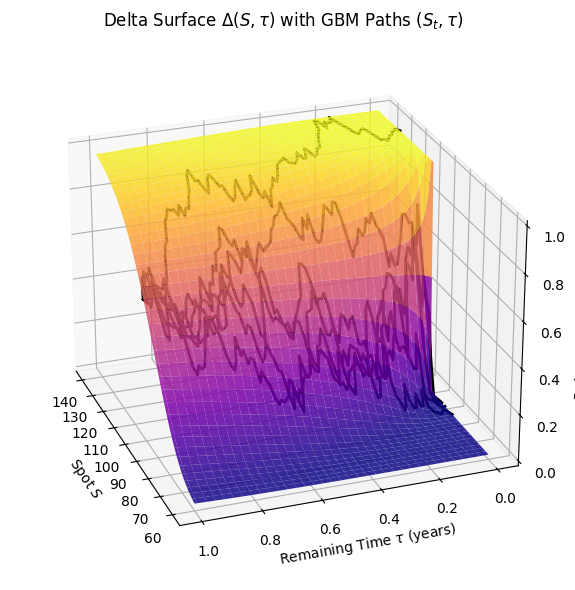

In [10]:
# Cell B — Delta surface Δ(S, τ) with GBM paths (risk-neutral)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import optpricer as op

# Reuse S_vals, Tau_vals if defined; else set them
S_vals  = globals().get("S_vals",  np.linspace(0.6*S0, 1.4*S0, 121))
Tau_vals= globals().get("Tau_vals",np.linspace(1e-4, T, 101))
Sg, Tg = np.meshgrid(S_vals, Tau_vals, indexing="xy")

Delta = np.empty_like(Sg, dtype=float)
for i, tau in enumerate(Tau_vals):
    for j, s in enumerate(S_vals):
        spec = op.OptionSpec(S0=float(s), K=K, T=float(tau), r=r, sigma=sig, q=q)
        g = op.bs_greeks(spec, kind=op.CALL)
        Delta[i, j] = g["delta"] if isinstance(g, dict) else g.delta

# If A's paths exist, reuse; otherwise generate
if "S_paths" not in globals():
    def gbm_paths(S0, r, q, sigma, T, steps, n_paths, seed=None):
        rng = np.random.default_rng(seed)
        dt = T/steps
        nudt = (r - q - 0.5*sigma**2)*dt
        sdt  = sigma*np.sqrt(dt)
        Z = rng.standard_normal((n_paths, steps))
        logS = np.log(S0) + np.cumsum(nudt + sdt*Z, axis=1)
        S = np.concatenate([np.full((n_paths,1), S0), np.exp(logS)], axis=1)
        t = np.linspace(0.0, T, steps+1)
        return t, S
    t, S_paths = gbm_paths(S0, r, q, sig, T, steps=100, n_paths=6, seed=42)

Tau_path = T - t
Delta_paths = np.empty_like(S_paths)
for k in range(S_paths.shape[0]):
    for m, (s, tau) in enumerate(zip(S_paths[k], Tau_path)):
        spec = op.OptionSpec(S0=float(s), K=K, T=float(max(tau, 1e-8)), r=r, sigma=sig, q=q)
        g = op.bs_greeks(spec, kind=op.CALL)
        d = g["delta"] if isinstance(g, dict) else g.delta
        Delta_paths[k, m] = d

# Plot
fig = plt.figure(figsize=(8.5,6))
ax = fig.add_subplot(111, projection="3d")
# surf = ax.plot_surface(Sg, Tg, Delta, cmap="viridis", linewidth=0, antialiased=True, alpha=0.9)
surf = ax.plot_surface(Sg, Tg, Delta, cmap="plasma", linewidth=0, antialiased=True, alpha=0.85)

for k in range(S_paths.shape[0]):
    ax.plot(S_paths[k], Tau_path, Delta_paths[k], color='black', linewidth=2)

ax.set_xlabel(r"Spot $S$")
ax.set_ylabel(r"Remaining Time $\tau$ (years)")
ax.set_zlabel(r"Delta $\Delta(S,\tau)$")
ax.set_title(r"Delta Surface $\Delta(S,\tau)$ with GBM Paths $(S_t,\tau)$")
ax.view_init(elev=25, azim=-200)
plt.tight_layout()
plt.show()


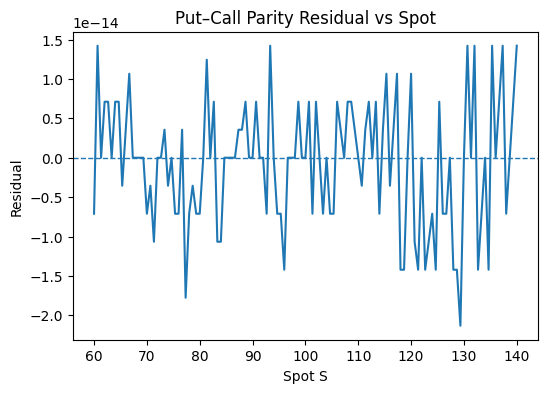

In [11]:
parity_resid = []
for s in S_vals:
    spec = op.OptionSpec(S0=float(s), K=K, T=T, r=r, sigma=sig, q=q)
    c = op.bs_price(spec, kind=op.CALL)
    p = op.bs_price(spec, kind=op.PUT)
    resid = c - p - (s*np.exp(-q*T) - K*np.exp(-r*T))
    parity_resid.append(resid)

plt.figure(figsize=(6,4))
plt.plot(S_vals, parity_resid)
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("Spot S"); plt.ylabel("Residual")
plt.title("Put–Call Parity Residual vs Spot")
plt.show()


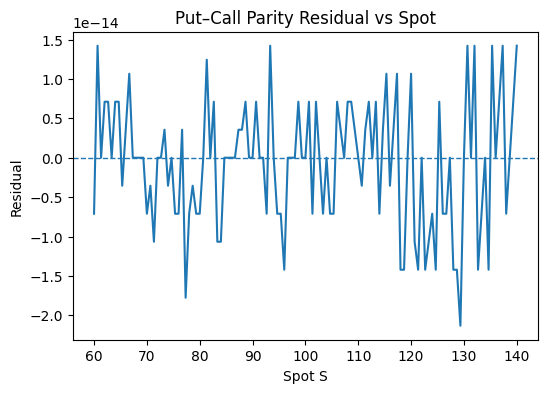

In [12]:
parity_resid = []
for s in S_vals:
    spec = op.OptionSpec(S0=float(s), K=K, T=T, r=r, sigma=sig, q=q)
    c = op.bs_price(spec, kind=op.CALL)
    p = op.bs_price(spec, kind=op.PUT)
    resid = c - p - (s*np.exp(-q*T) - K*np.exp(-r*T))
    parity_resid.append(resid)

plt.figure(figsize=(6,4))
plt.plot(S_vals, parity_resid)
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("Spot S"); plt.ylabel("Residual")
plt.title("Put–Call Parity Residual vs Spot")
plt.show()


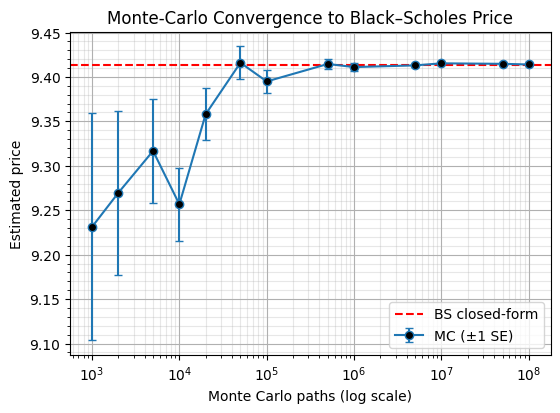

In [13]:
# Convergence with theoretical line + std error bars (uses new euro_price_mc)
Ns = [1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000, 500_000, 1_000_000, 5_000_000, 10_000_000, 50_000_000, 100_000_000]
pxs, ses = [], []

for N in Ns:
    spec = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=sig, q=q)
    px, se = op.euro_price_mc(spec, op.CALL,
                              n_paths=N, seed=42,
                              chunk_size=100_000,     # cap memory
                              antithetic=True,        # variance reduction
                              control_variate=True,   # strong variance reduction
                              n_workers=10)            # safe in notebooks; bump in scripts
    pxs.append(px); ses.append(se)

pxs, ses = np.array(pxs), np.array(ses)

theo = op.bs_price(op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=sig, q=q), kind=op.CALL)

plt.figure(figsize=(6.2,4.2))
plt.errorbar(Ns, pxs, yerr=ses, marker="o", markerfacecolor='black', linestyle="-", capsize=3, label="MC (±1 SE)")
plt.axhline(theo, linestyle="--", linewidth=1.5, label="BS closed-form", color="red")

plt.xscale("log")
plt.xlabel("Monte Carlo paths (log scale)")
plt.ylabel("Estimated price")
plt.title("Monte-Carlo Convergence to Black–Scholes Price")
plt.minorticks_on(); plt.grid(True, which="both"); plt.grid(which="minor", alpha=0.3)
plt.legend()
plt.show()
